In [ ]:
# delete non useful columns
df = df.drop(columns=["Common Name", "Medicinal Rating", "Common Names", "Scientific Name", "Summary", "Edibility Rating", "Image URLs"])

## Neural Network
Medicinal rating (Low, Medium, High).

Dataset shape: (14283, 3323)
Columns: ['Use', 'Scientific name', 'Common name', 'Edibility rating', 'Medicinal rating', 'Care requirements', 'Cultivation details', 'Edible uses', 'Plant family', 'Known hazards', 'Medicinal properties', 'Native area', 'Other uses', 'Other uses rating', 'Propagation', 'Diffusion area', 'Special uses', 'USDA hardiness zone', 'Weed potential', 'Medicinal rating class', 'MedProp_Antipyretic Astringent Cancer Tonic', 'MedProp_Antirheumatic Antiseborrheic Cancer Cathartic Diuretic Emetic Homeopathy Rubefacient Stimulant Vesicant', 'MedProp_Antianxiety Antirheumatic Antiseptic Bach Cholagogue Depurative Diaphoretic Diuretic Expectorant Sedative Urinary Vasoconstrictor', 'MedProp_Anodyne Aperient Diuretic Emetic Galactogogue Rubefacient Stimulant', 'MedProp_Antirheumatic Astringent Vitamin C', 'MedProp_Carminative Refrigerant', 'MedProp_Acrid Emetic Odontalgic Sialagogue Vesicant', 'MedProp_Antiseptic Haemostatic Salve Skin Styptic', 'MedProp_Abortifacient Anal

2025-07-16 23:37:17.857755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - ETA: 0s - loss: 9.9683 - accuracy: 0.3728

2025-07-16 23:37:21.220402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 4s 14ms/step - loss: 9.9683 - accuracy: 0.3728 - val_loss: 4.0555 - val_accuracy: 0.4497
Epoch 2/50
286/286 [==============================] - 4s 13ms/step - loss: 7.5696 - accuracy: 0.3993 - val_loss: 3.4211 - val_accuracy: 0.5157
Epoch 3/50
286/286 [==============================] - 4s 13ms/step - loss: 6.7819 - accuracy: 0.3998 - val_loss: 3.1662 - val_accuracy: 0.5157
Epoch 4/50
286/286 [==============================] - 4s 13ms/step - loss: 6.2805 - accuracy: 0.3986 - val_loss: 3.1231 - val_accuracy: 0.4873
Epoch 5/50
286/286 [==============================] - 4s 13ms/step - loss: 5.6314 - accuracy: 0.4028 - val_loss: 3.0156 - val_accuracy: 0.4777
Epoch 6/50
286/286 [==============================] - 4s 13ms/step - loss: 5.1386 - accuracy: 0.3946 - val_loss: 2.8280 - val_accuracy: 0.4869
Epoch 7/50
286/286 [==============================] - 4s 13ms/step - loss: 4.5292 - accuracy: 0.3945 - val_loss: 2.6157 - val_accuracy: 0.5048
Epoch 8/50

2025-07-16 23:40:32.083459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


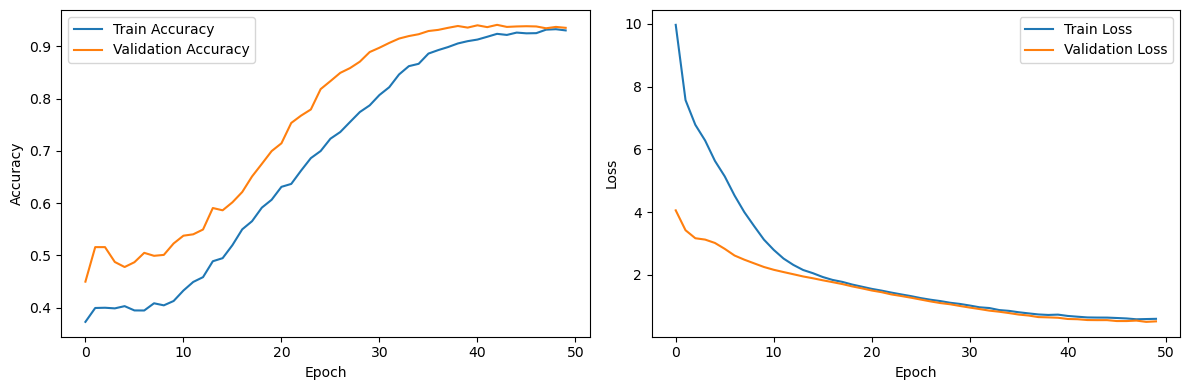

Model saved as 'pfaf_medicinal_rating_model.h5'
Preprocessors saved as 'scaler.pkl', 'tfidf.pkl', 'label_encoder.pkl'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Verify dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")

# Apply column renaming
df = df.rename(columns={
    "use_keyword": "Use",
    "latin_name_search": "Scientific name",
    "common_name_search": "Common name",
    "edibility_rating_search": "Edibility rating",
    "medicinal_rating_search": "Medicinal rating",
    "plant_url": "Plant URL",
    "Care Requirements": "Care requirements",
    "Cultivation Details": "Cultivation details",
    "Edible Uses": "Edible uses",
    "Family": "Plant family",
    "Known Hazards": "Known hazards",
    "Medicinal Properties": "Medicinal properties",
    "Native Range": "Native area",
    "Other Uses": "Other uses",
    "Other Uses Rating": "Other uses rating",
    "Propagation": "Propagation",
    "Range": "Diffusion area",
    "Special Uses": "Special uses",
    "USDA hardiness": "USDA hardiness zone",
    "Weed Potential": "Weed potential"
})

# Drop irrelevant columns
df = df.drop(columns=['Plant URL'], errors='ignore')

# Handle missing values
for col in ['Edibility rating', 'Medicinal rating', 'Other uses rating']:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

# Convert list-like columns to strings
text_cols = ['Care requirements', 'Cultivation details', 'Edible uses', 'Known hazards', 
             'Medicinal properties', 'Native area', 'Other uses', 'Propagation', 
             'Diffusion area', 'Special uses']
for col in text_cols:
    df[col] = df[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Create binary features for 'Medicinal properties'
all_properties = set()
df['Medicinal properties'].str.split(', ').apply(lambda x: all_properties.update(x))
all_properties.discard('')
property_counts = df['Medicinal properties'].str.split(', ', expand=True).stack().value_counts()
top_properties = property_counts.head(25).index.tolist()
binary_features = pd.DataFrame({
    f'MedProp_{prop}': df['Medicinal properties'].apply(lambda x: 1 if prop in str(x) else 0)
    for prop in top_properties
})
df = pd.concat([df, binary_features], axis=1)

# Define target: Bin 'Medicinal rating'
bins = [-float('inf'), 1, 2, float('inf')]
labels = ['Low', 'Medium', 'High']
df['Medicinal rating class'] = pd.cut(df['Medicinal rating'], bins=bins, labels=labels)

# Verify target distribution
print(f"Target distribution:\n{df['Medicinal rating class'].value_counts()}")

# Define features
numerical_cols = ['Edibility rating', 'Other uses rating'] + [col for col in df.columns if col.startswith('MedProp_')]
categorical_cols = ['Use', 'Plant family', 'USDA hardiness zone', 'Weed potential']
text_cols = ['Care requirements', 'Cultivation details', 'Edible uses', 'Known hazards', 
             'Medicinal properties', 'Native area', 'Other uses', 'Propagation', 
             'Diffusion area', 'Special uses']

# Encode categorical features
le = LabelEncoder()
X_categorical = df[categorical_cols].copy()
for col in categorical_cols:
    X_categorical[col] = le.fit_transform(X_categorical[col].astype(str))

# Scale numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[numerical_cols])

# Process text features with TF-IDF
tfidf = TfidfVectorizer(max_features=30, stop_words='english')
X_text = np.hstack([tfidf.fit_transform(df[col]).toarray() for col in text_cols])

# Combine all features
X = np.hstack([X_numerical, X_categorical, X_text])
print(f"Feature matrix shape: {X.shape}")

# Encode target
y = le.fit_transform(df['Medicinal rating class'])
y = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_labels = np.argmax(y_train, axis=1)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))
print("Final Model Class Weights:", class_weight_dict)

# Define and train model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.02)),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_split=0.2, class_weight=class_weight_dict, 
                    callbacks=[early_stopping], verbose=1)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

# Classification report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print("Final Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=labels))

# Visualize training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model and preprocessors
model.save('pfaf_medicinal_rating_model.h5')
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(tfidf, 'tfidf.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model saved as 'pfaf_medicinal_rating_model.h5'")
print("Preprocessors saved as 'scaler.pkl', 'tfidf.pkl', 'label_encoder.pkl'")

# will work on this later

In [ ]:
#from tensorflow.keras.models import load_model
# import joblib
#import numpy as np

# Load the model and preprocessors
#model = load_model('pfaf_medicinal_rating_model.h5')
#scaler = joblib.load('scaler.pkl')
#tfidf = joblib.load('tfidf.pkl')
#le = joblib.load('label_encoder.pkl')

# Example: Predict on new data (replace with preprocessed X_new)
# X_new = ... (same format as X: numerical, categorical, TF-IDF)
# y_pred = model.predict(X_new)
# y_pred_labels = np.argmax(y_pred, axis=1)
# predicted_classes = le.inverse_transform(y_pred_labels)